In [45]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 경로 설정

In [46]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.hdf5'

# 분류 수 설정

In [47]:
NUM_CLASSES = 18

# 학습데이터 불러오기

In [48]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [49]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# 모델구축

In [51]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [52]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_4 (Dropout)         (None, 42)                0         
                                                                 
 dense_6 (Dense)             (None, 64)                2752      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 18)                594       
                                                                 
Total params: 5,426
Trainable params: 5,426
Non-trainable params: 0
_________________________________________________________________


In [53]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [54]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# 모델 훈련

In [55]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 87/114 [=====================>........] - ETA: 0s - loss: 2.3870 - accuracy: 0.2683 
Epoch 00001: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
114/114 [==============================] - 0s 1ms/step - loss: 2.2442 - accuracy: 0.3242 - val_loss: 1.3502 - val_accuracy: 0.7665
Epoch 2/1000
 77/114 [===================>..........] - ETA: 0s - loss: 1.3259 - accuracy: 0.5900
Epoch 00002: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
114/114 [==============================] - 0s 893us/step - loss: 1.2201 - accuracy: 0.6158 - val_loss: 0.5843 - val_accuracy: 0.8258
Epoch 3/1000
 74/114 [==================>...........] - ETA: 0s - loss: 0.8588 - accuracy: 0.7089
Epoch 00003: saving model to model/keypoint_classifier/keypoint_classifier.hdf5
114/114 [==============================] - 0s 908us/step - loss: 0.8286 - accuracy: 0.7184 - val_loss: 0.3731 - val_accuracy: 0.9054
Epoch 4/1000
 79/114 [===================>..........] - ETA: 0s - lo

In [56]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

38/38 [==============================] - 0s 382us/step - loss: 0.0408 - accuracy: 0.9844


In [57]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [58]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

[2.2698374e-07 2.5570457e-11 9.9471551e-01 2.3325514e-10 5.3082518e-14
 3.7406307e-11 2.6752419e-05 1.7438429e-08 1.8340284e-06 5.2305367e-03
 1.1829623e-05 2.5265350e-09 2.1253000e-17 1.3978583e-09 1.3381025e-05
 6.0656207e-12 1.5572484e-12 7.2835259e-11]
2


# 시각화(confusion_matrix)

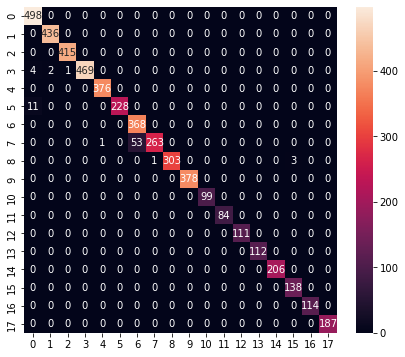

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       498
           1       1.00      1.00      1.00       436
           2       1.00      1.00      1.00       415
           3       1.00      0.99      0.99       476
           4       1.00      1.00      1.00       376
           5       1.00      0.95      0.98       239
           6       0.87      1.00      0.93       368
           7       1.00      0.83      0.91       317
           8       1.00      0.99      0.99       307
           9       1.00      1.00      1.00       378
          10       1.00      1.00      1.00        99
          11       1.00      1.00      1.00        84
          12       1.00      1.00      1.00       111
          13       1.00      1.00      1.00       112
          14       1.00      1.00      1.00       206
          15       0.98      1.00      0.99       138
          16       1.00      1.00      1.00       114
     

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite용 모델로 변환

In [60]:
# 추론 전용 모델로 저장
model.save(model_save_path, include_optimizer=False)

In [61]:
# 모델변환(양자화)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpcq_hckt6/assets


INFO:tensorflow:Assets written to: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpcq_hckt6/assets
2022-06-28 14:31:36.533200: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:363] Ignored output_format.
2022-06-28 14:31:36.533213: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:366] Ignored drop_control_dependency.
2022-06-28 14:31:36.533297: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpcq_hckt6
2022-06-28 14:31:36.534101: I tensorflow/cc/saved_model/reader.cc:107] Reading meta graph with tags { serve }
2022-06-28 14:31:36.534106: I tensorflow/cc/saved_model/reader.cc:148] Reading SavedModel debug info (if present) from: /var/folders/yl/3qq35jrn65z0p93ls3scx5s80000gn/T/tmpcq_hckt6
2022-06-28 14:31:36.536962: I tensorflow/cc/saved_model/loader.cc:210] Restoring SavedModel bundle.
2022-06-28 14:31:36.558468: I tensorflow/cc/saved_model/loader.cc:194] Running initializatio

9552

# 추론 테스트

In [62]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [63]:
# 입출력 텐서 얻기
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [64]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [65]:
%%time
# 추론 실시
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 66 µs, sys: 37 µs, total: 103 µs
Wall time: 86.8 µs


In [66]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[2.21440985e-07 3.28540355e-11 9.93933976e-01 3.13343712e-10
 7.88077963e-14 4.53726084e-11 3.12161283e-05 2.22507595e-08
 2.22650237e-06 6.00631116e-03 1.17645923e-05 3.40610651e-09
 3.18425162e-17 1.97830929e-09 1.43046445e-05 7.96529336e-12
 1.91561957e-12 8.99163660e-11]
2
